#**Producing a Multi-step Forecast**

In this example, we are going to work with the professor's step tracking data from Google Fit. We will create a stacked LSTM model for predicting steps taken 1, 3 and 5 days ahead, based on a historical sequence of 21 days of step activity.

In [ ]:
# Grab the data from my github repository: 

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Let's load the step / calorie data (it's daily), drop the Date timestamp, and just focus on the steps time series.

In [ ]:
import pandas as pd 
import numpy as np

df = pd.read_csv('drive/My Drive/Teaching/Courses/BA 865/Pre-Release/Week 6/datasets/gb_steps_cals.csv')
df['Date']=pd.to_datetime(df['Date'],format='%m/%d/%Y', infer_datetime_format=True).dt.date

steps = df['Step count'].to_numpy()

# We have some missing values which I am going to replace with a simple average. 
steps_mean = np.nanmean(steps, axis=0)
inds = np.where(np.isnan(steps))[0]
steps[inds] = steps_mean

df.describe(include='all')

,Date,Calories (kcal),Step count
count,1828,1828.000000,1828.000000
unique,1828,NaN,NaN
top,2016-11-05,NaN,NaN
freq,1,NaN,NaN
mean,NaN,2098.109378,4614.465052
std,NaN,314.537769,2831.535177
min,NaN,29.087395,93.000000
25%,NaN,1898.548554,2615.000000
50%,NaN,2067.743241,4322.000000
75%,NaN,2256.225360,6024.750000


We can visualize the step patterns a bit... clearly I am too sedentary.

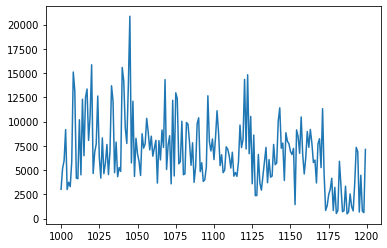

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_smooth.py:168: PlotnineWarning: No 'window' specified in the method_args. Using window = 182. The same window is used for all groups or facets
  "facets".format(window), PlotnineWarning)


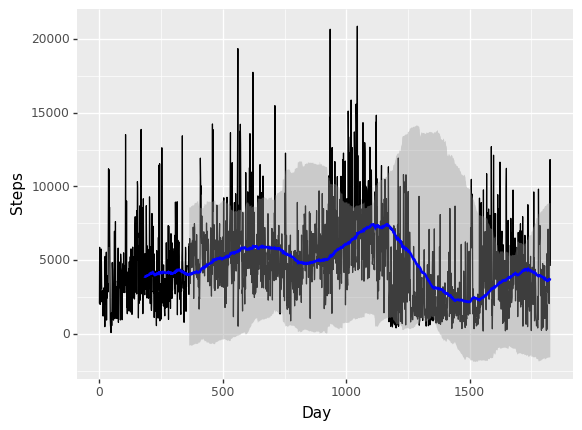

<ggplot: (8762423168785)>

In [ ]:
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, xlab, ylab, geom_smooth

ggplot = ggplot(df,aes(y='Step count',x=range(len(df)))) + geom_line() + geom_smooth(method='mavg',color='blue') + xlab('Day') + ylab('Steps')

plt.plot(range(1000,1200),steps[1000:1200])
plt.show()
ggplot

Now we need to construct our dataset. Before we used TF Dataset generators, but we can also create a dataset from scratch as follows... 

In [ ]:
import math

num_training_obs = math.floor(len(steps)*0.5)
num_validation_obs = math.floor(len(steps)*0.25)
num_test_obs = len(steps)-num_validation_obs-num_training_obs

train_series = steps[:num_training_obs]
validation_series = steps[num_training_obs:num_training_obs+num_validation_obs]
test_series = steps[num_training_obs+num_validation_obs:]

print(num_training_obs)
print(num_validation_obs)
print(num_test_obs)

914
457
457


I'm going to create sequences of 21 days for training, using logged calories. Because I want to obtain multi-step forecasts, e.g., over 1 day, 5 days, 10 days, I'm also going to create those labels for each sample. Note that I am going to subtract 1 of the specified 'horizons' because of 0 indexing.

In [ ]:
def make_samples(seq_length,horizons,sample):

  num_obs = sample.shape[0]

  X_data = np.zeros(shape=(num_obs-seq_length-max(horizons)-1,seq_length))
  Y_data = np.zeros(shape=(num_obs-seq_length-max(horizons)-1,len(horizons)))
  for i in range(num_obs-seq_length-max(horizons)-1):
    X_data[i,:] = sample[i:i+seq_length]
    for j in range(len(horizons)):
      Y_data[i,j] = sample[i+seq_length+horizons[j]-1]

  shuffle_index = np.arange(X_data.shape[0])
  np.random.shuffle(shuffle_index)
  
  return X_data[shuffle_index], Y_data[shuffle_index]

train_obs, train_labels = make_samples(seq_length=21, horizons=[1,3,5] , sample = train_series)
val_obs, val_labels = make_samples(seq_length=21, horizons=[1,3,5], sample = validation_series)
test_obs, test_labels = make_samples(seq_length = 21, horizons=[1,3,5], sample=test_series)

So, we end up with 888 observations (Note: 914 - 21 - 5 = 888)...

In [ ]:
print(train_obs.shape)
print(train_labels.shape)

print(train_obs[886])
print(train_labels[0])
print(train_series[0:27])

(887, 21)
(887, 3)
[2639. 5611. 5422. 3966. 3605. 4146. 5134. 2145. 6703. 3350. 4289. 4070.
 4471. 3753. 4534. 7370. 6355. 5406. 4813. 8132. 7830.]
[1624. 4415. 4894.]
[2062. 5874. 2267. 2003. 4216. 3259. 3106. 5758. 5017. 3415. 2862. 2165.
 2917. 2852. 2883. 1214. 2366. 2197. 3127. 3106. 1477. 3138.  493. 5259.
 2979. 2729. 2031.]


Now we can define our Neural Network and a custom loss function for capturing the error at different prediction horizons... it's your choice how you want to structure the model. You can have three separate one-dimensional outputs, or you could have a single, 3-element vector output in the final layer. Either way, you just need to pass the data to the fit command with the associated structure.

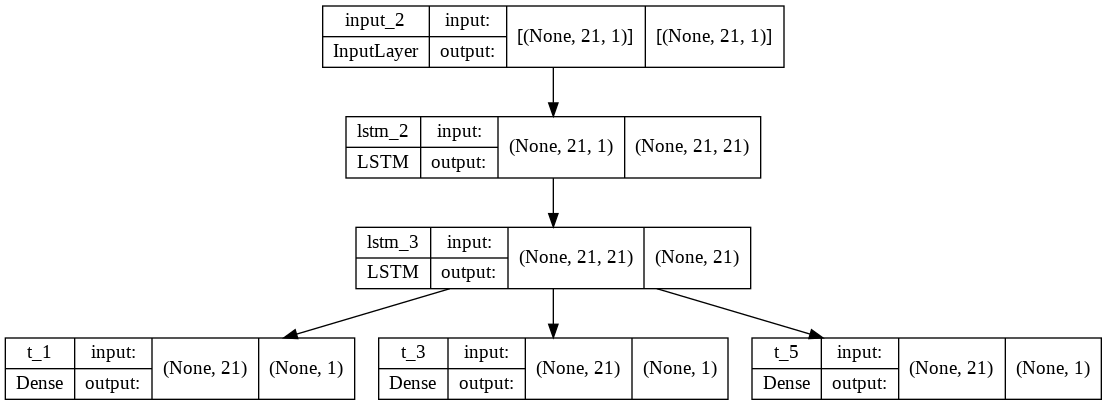

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

inputs = layers.Input(shape=(21,1)) # Sequence length of 21, just 1 feature.
x = layers.LSTM(21,return_sequences=True)(inputs) # We are only considering 7 lags / time-steps here.
x = layers.LSTM(21)(x)
output_1 = layers.Dense(1, name="t_1")(x)
output_2 = layers.Dense(1, name="t_3")(x)
output_3 = layers.Dense(1, name="t_5")(x)

model = keras.Model(inputs=inputs, outputs = [output_1,output_2,output_3])

# Note that the loss weights indicate that the model should focus 5x as much on the one step ahead prediction, as compared to the 5 step ahead. 
losses = {
	"t_1": "mae",
	"t_3": "mae",
  "t_5": "mae",
}
lossWeights = {"t_1": 2.0, "t_3": 1.0, "t_5": 1.0}

model.compile(optimizer="rmsprop",loss=losses, loss_weights=lossWeights)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("drive/My Drive/Teaching/Courses/BA 865/Pre-Release/Week 6/steps.keras",
                    save_best_only=True)
]

history = model.fit(x=train_obs,y=[train_labels[:,0], train_labels[:,1], train_labels[:,2]],
                    validation_data=(val_obs,[val_labels[:,0], val_labels[:,1], val_labels[:,2]]),
                    batch_size=25,epochs=10000, callbacks = callbacks)

Streaming output truncated to the last 5000 lines.
36/36 [==============================] - 0s 8ms/step - loss: 6991.3208 - t_1_loss: 1748.2400 - t_3_loss: 1746.8752 - t_5_loss: 1747.9646 - val_loss: 11008.5342 - val_t_1_loss: 2771.9370 - val_t_3_loss: 2728.0015 - val_t_5_loss: 2736.6594
Epoch 7502/10000
36/36 [==============================] - 0s 8ms/step - loss: 6991.3198 - t_1_loss: 1748.2396 - t_3_loss: 1746.8761 - t_5_loss: 1747.9650 - val_loss: 11008.5371 - val_t_1_loss: 2771.9395 - val_t_3_loss: 2727.9985 - val_t_5_loss: 2736.6599
Epoch 7503/10000
36/36 [==============================] - 0s 8ms/step - loss: 6991.3184 - t_1_loss: 1748.2396 - t_3_loss: 1746.8760 - t_5_loss: 1747.9656 - val_loss: 11008.5352 - val_t_1_loss: 2771.9390 - val_t_3_loss: 2727.9980 - val_t_5_loss: 2736.6589
Epoch 7504/10000
36/36 [==============================] - 0s 8ms/step - loss: 6991.3213 - t_1_loss: 1748.2411 - t_3_loss: 1746.8752 - t_5_loss: 1747.9642 - val_loss: 11008.5342 - val_t_1_loss: 2771.939

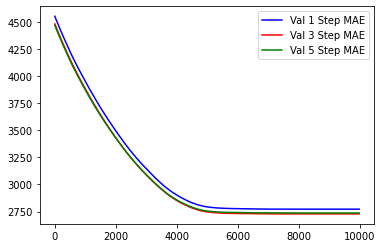

14/14 [==============================] - 1s 3ms/step - loss: 8935.1348 - t_1_loss: 2233.7717 - t_3_loss: 2233.8052 - t_5_loss: 2233.7866
Test loss is: [8935.134765625, 2233.771728515625, 2233.80517578125, 2233.78662109375].


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_t_1_loss'][25:],c='b')
plt.plot(history.history['val_t_3_loss'][25:],c='r')
plt.plot(history.history['val_t_5_loss'][25:],c='g')
plt.legend(['Val 1 Step MAE','Val 3 Step MAE', 'Val 5 Step MAE'])
plt.show()

print(f'Test loss is: {model.evaluate(test_obs,test_labels)}.')